In [28]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import KFold,StratifiedKFold

In [29]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

D:\Anoconda3\envs\tf\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [30]:
def build_network():
    os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\based_model\5k\Acet&&Ubi_CNN_OH')
    cnn = load_model('dataoh.h5')
    cnn.trainable = True #固定所有预训练模型层的参数
    base_model = Model(inputs=cnn.layers[0].input,outputs=cnn.layers[8].output)
    base_model.summary()
    base_model.trainable = True
    for layer in base_model.layers[:0]:
        layer.trainable = False
    Dense = tf.keras.layers.Dense(64,activation=tf.nn.relu)
    global_average_layer = tf.keras.layers.GlobalAveragePooling1D()
    prediction_layer = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
    model1 = tf.keras.Sequential([
        base_model,
        #layers.Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu),
        #layers.Dropout(0.5),
        Dense,
        layers.Dropout(0.5),
        global_average_layer,
        prediction_layer
    ])
    base_learning_rate = 0.002
    model1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])#编译模型
    #model1.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    #model1.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
    model1.summary()
    return model1

In [31]:
def One_hot_raw(path):
    seqs = open(path).readlines()

    X1 = [seq.split()[1] for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[0]) for seq in seqs if seq.strip() != '']
    One = []
    for i in range(0, len(X1)):
        One.append(list(X1[i]))
    X = pd.DataFrame(One)
    return np.array(X), np.array(y)


def one_hot(rawDataFrame, codingMode=0):  # rawDataFrame is numpy.ndarray

    sampleSeq3DArr = rawDataFrame[:, :]

    if codingMode == 0:
        probMatr = convertSampleToProbMatr(sampleSeq3DArr)

    return probMatr


def convertSampleToProbMatr(sampleSeq3DArr):  # changed add one column for '1'

    letterDict = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, "M": 10, "N": 11,
                  "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19, "X": 20}
    AACategoryLen = 21  # add -

    probMatr = np.zeros((len(sampleSeq3DArr), 1, len(sampleSeq3DArr[0]), AACategoryLen))

    sampleNo = 0
    for sequence in sampleSeq3DArr:

        AANo = 0
        for AA in sequence:

            if not AA in letterDict:
                probMatr[sampleNo][0][AANo] = np.full((1, AACategoryLen), 1.0 / AACategoryLen)

            else:
                index = letterDict[AA]
                probMatr[sampleNo][0][AANo][index] = 1

            AANo += 1
        sampleNo += 1

    return probMatr

In [32]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [33]:
batch_size=256

In [34]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\迁移数据\训练集')
epochs = 300
x_train,y_train = One_hot_raw('train.txt')#十折交叉验证10
x_test,y_test = One_hot_raw('test.txt')#独立测试1

In [35]:
classes = sorted(list(set(y_train)))
x_train = one_hot(x_train)
x_test = one_hot(x_test)
x_train.shape = (x_train.shape[0],x_train.shape[2],x_train.shape[3])
x_test.shape = (x_test.shape[0],x_test.shape[2],x_test.shape[3])

In [36]:
# 构建独立测试集对象，预处理，批量化
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.map(preprocess).batch(batch_size)

In [37]:
prediction_result_cv = []
prediction_result_ind = []

In [38]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi')

In [39]:
out = os.getcwd() + '\\'

In [40]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    model1 = build_network()
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = model1.fit(train_db, epochs=epochs, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = model1.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = model1.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15_input (InputLayer) [(None, 41, 21)]          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 41, 128)           2816      
_________________________________________________________________
dropout_15 (Dropout)         (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 20, 128)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 20, 128)           49280     
_________________________________________________________________
dropout_16 (Dropout)         (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 10, 128)           0  


Epoch 00026: val_loss did not improve from 0.50217
Epoch 27/300
8/8 - 0s - loss: 0.4871 - accuracy: 0.7533 - val_loss: 0.5173 - val_accuracy: 0.7644

Epoch 00027: val_loss did not improve from 0.50217
Epoch 28/300
8/8 - 0s - loss: 0.4532 - accuracy: 0.7810 - val_loss: 0.5256 - val_accuracy: 0.7422

Epoch 00028: val_loss did not improve from 0.50217
Epoch 29/300
8/8 - 0s - loss: 0.4805 - accuracy: 0.7751 - val_loss: 0.5185 - val_accuracy: 0.7422

Epoch 00029: val_loss did not improve from 0.50217
Epoch 30/300
8/8 - 0s - loss: 0.4603 - accuracy: 0.7776 - val_loss: 0.5055 - val_accuracy: 0.7333

Epoch 00030: val_loss did not improve from 0.50217
Epoch 31/300
8/8 - 0s - loss: 0.4411 - accuracy: 0.7845 - val_loss: 0.5381 - val_accuracy: 0.7156

Epoch 00031: val_loss did not improve from 0.50217
Epoch 32/300
8/8 - 0s - loss: 0.4588 - accuracy: 0.7736 - val_loss: 0.5106 - val_accuracy: 0.7333

Epoch 00032: val_loss did not improve from 0.50217
Epoch 33/300
8/8 - 0s - loss: 0.4545 - accuracy:


Epoch 00078: val_loss did not improve from 0.48767
Epoch 79/300
8/8 - 0s - loss: 0.2636 - accuracy: 0.8913 - val_loss: 0.5399 - val_accuracy: 0.7022

Epoch 00079: val_loss did not improve from 0.48767
Epoch 80/300
8/8 - 0s - loss: 0.2585 - accuracy: 0.8853 - val_loss: 0.5116 - val_accuracy: 0.7333

Epoch 00080: val_loss did not improve from 0.48767
Epoch 81/300
8/8 - 0s - loss: 0.2405 - accuracy: 0.9001 - val_loss: 0.5655 - val_accuracy: 0.7156

Epoch 00081: val_loss did not improve from 0.48767
Epoch 82/300
8/8 - 0s - loss: 0.3085 - accuracy: 0.8651 - val_loss: 0.4974 - val_accuracy: 0.7422

Epoch 00082: val_loss did not improve from 0.48767
Epoch 83/300
8/8 - 0s - loss: 0.2326 - accuracy: 0.9056 - val_loss: 0.5179 - val_accuracy: 0.7378

Epoch 00083: val_loss did not improve from 0.48767
Epoch 84/300
8/8 - 0s - loss: 0.2932 - accuracy: 0.8710 - val_loss: 0.4964 - val_accuracy: 0.7289

Epoch 00084: val_loss did not improve from 0.48767
Epoch 85/300
8/8 - 0s - loss: 0.2434 - accuracy:

8/8 - 0s - loss: 0.5669 - accuracy: 0.7123 - val_loss: 0.5673 - val_accuracy: 0.7111

Epoch 00008: val_loss improved from 0.57066 to 0.56733, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\_1.h5
Epoch 9/300
8/8 - 0s - loss: 0.5872 - accuracy: 0.6812 - val_loss: 0.5740 - val_accuracy: 0.7156

Epoch 00009: val_loss did not improve from 0.56733
Epoch 10/300
8/8 - 0s - loss: 0.5691 - accuracy: 0.7039 - val_loss: 0.6001 - val_accuracy: 0.6889

Epoch 00010: val_loss did not improve from 0.56733
Epoch 11/300
8/8 - 0s - loss: 0.5503 - accuracy: 0.7098 - val_loss: 0.5728 - val_accuracy: 0.6889

Epoch 00011: val_loss did not improve from 0.56733
Epoch 12/300
8/8 - 0s - loss: 0.5541 - accuracy: 0.7123 - val_loss: 0.5659 - val_accuracy: 0.7022

Epoch 00012: val_loss improved from 0.56733 to 0.56594, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\d


Epoch 00050: val_loss did not improve from 0.50878
Epoch 51/300
8/8 - 0s - loss: 0.4129 - accuracy: 0.8201 - val_loss: 0.5169 - val_accuracy: 0.7511

Epoch 00051: val_loss did not improve from 0.50878
Epoch 52/300
8/8 - 0s - loss: 0.3335 - accuracy: 0.8591 - val_loss: 0.5019 - val_accuracy: 0.7689

Epoch 00052: val_loss improved from 0.50878 to 0.50188, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\_1.h5
Epoch 53/300
8/8 - 0s - loss: 0.4018 - accuracy: 0.8270 - val_loss: 0.5124 - val_accuracy: 0.7244

Epoch 00053: val_loss did not improve from 0.50188
Epoch 54/300
8/8 - 0s - loss: 0.3341 - accuracy: 0.8626 - val_loss: 0.6019 - val_accuracy: 0.6444

Epoch 00054: val_loss did not improve from 0.50188
Epoch 55/300
8/8 - 0s - loss: 0.3641 - accuracy: 0.8339 - val_loss: 0.5005 - val_accuracy: 0.7378

Epoch 00055: val_loss improved from 0.50188 to 0.50049, saving model to D:\PycharmProjects\pythonProject\P


Epoch 00102: val_loss did not improve from 0.49288
Epoch 103/300
8/8 - 0s - loss: 0.2282 - accuracy: 0.9095 - val_loss: 0.5086 - val_accuracy: 0.7511

Epoch 00103: val_loss did not improve from 0.49288
Epoch 104/300
8/8 - 0s - loss: 0.1803 - accuracy: 0.9313 - val_loss: 0.5528 - val_accuracy: 0.7156

Epoch 00104: val_loss did not improve from 0.49288
Epoch 105/300
8/8 - 0s - loss: 0.2233 - accuracy: 0.9086 - val_loss: 0.5278 - val_accuracy: 0.7289

Epoch 00105: val_loss did not improve from 0.49288
Epoch 106/300
8/8 - 0s - loss: 0.1824 - accuracy: 0.9298 - val_loss: 0.5216 - val_accuracy: 0.7333

Epoch 00106: val_loss did not improve from 0.49288
Epoch 107/300
8/8 - 0s - loss: 0.3017 - accuracy: 0.8749 - val_loss: 0.5373 - val_accuracy: 0.7022

Epoch 00107: val_loss did not improve from 0.49288
Epoch 108/300
8/8 - 0s - loss: 0.1802 - accuracy: 0.9254 - val_loss: 0.5270 - val_accuracy: 0.7422

Epoch 00108: val_loss did not improve from 0.49288
Epoch 109/300
8/8 - 0s - loss: 0.2212 - ac


Epoch 00014: val_loss did not improve from 0.57301
Epoch 15/300
8/8 - 0s - loss: 0.5166 - accuracy: 0.7350 - val_loss: 0.5660 - val_accuracy: 0.7244

Epoch 00015: val_loss improved from 0.57301 to 0.56598, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\_2.h5
Epoch 16/300
8/8 - 0s - loss: 0.5437 - accuracy: 0.7242 - val_loss: 0.5879 - val_accuracy: 0.7244

Epoch 00016: val_loss did not improve from 0.56598
Epoch 17/300
8/8 - 0s - loss: 0.5092 - accuracy: 0.7608 - val_loss: 0.5530 - val_accuracy: 0.7289

Epoch 00017: val_loss improved from 0.56598 to 0.55296, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\_2.h5
Epoch 18/300
8/8 - 0s - loss: 0.5146 - accuracy: 0.7459 - val_loss: 0.5752 - val_accuracy: 0.6978

Epoch 00018: val_loss did not improve from 0.55296
Epoch 19/300
8/8 - 0s - loss: 0.5282 - accuracy: 0.7321 - val_


Epoch 00062: val_loss did not improve from 0.52860
Epoch 63/300
8/8 - 0s - loss: 0.2701 - accuracy: 0.8878 - val_loss: 0.5956 - val_accuracy: 0.7111

Epoch 00063: val_loss did not improve from 0.52860
Epoch 64/300
8/8 - 0s - loss: 0.3599 - accuracy: 0.8443 - val_loss: 0.5562 - val_accuracy: 0.7022

Epoch 00064: val_loss did not improve from 0.52860
Epoch 65/300
8/8 - 0s - loss: 0.2661 - accuracy: 0.8913 - val_loss: 0.5407 - val_accuracy: 0.7244

Epoch 00065: val_loss did not improve from 0.52860
Epoch 66/300
8/8 - 0s - loss: 0.3150 - accuracy: 0.8646 - val_loss: 0.6261 - val_accuracy: 0.6667

Epoch 00066: val_loss did not improve from 0.52860
Epoch 67/300
8/8 - 0s - loss: 0.3200 - accuracy: 0.8571 - val_loss: 0.5530 - val_accuracy: 0.7244

Epoch 00067: val_loss did not improve from 0.52860
Epoch 68/300
8/8 - 0s - loss: 0.2528 - accuracy: 0.8873 - val_loss: 0.5968 - val_accuracy: 0.6844

Epoch 00068: val_loss did not improve from 0.52860
Epoch 69/300
8/8 - 0s - loss: 0.3079 - accuracy:

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_13 (Functional)        (None, 5, 128)            199680    
_________________________________________________________________
dense_26 (Dense)             (None, 5, 64)             8256      
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 64)             0         
_________________________________________________________________
global_average_pooling1d_13  (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 208,001
Trainable params: 208,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
8/8 - 1s - loss: 0.6673 - accuracy: 0.6006 - val_loss: 0.6148 - val_accuracy: 0.7022

Epoch 00001: va


Epoch 00036: val_loss did not improve from 0.52824
Epoch 37/300
8/8 - 0s - loss: 0.4114 - accuracy: 0.8097 - val_loss: 0.5274 - val_accuracy: 0.7511

Epoch 00037: val_loss improved from 0.52824 to 0.52743, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\_3.h5
Epoch 38/300
8/8 - 0s - loss: 0.4486 - accuracy: 0.7914 - val_loss: 0.5413 - val_accuracy: 0.7289

Epoch 00038: val_loss did not improve from 0.52743
Epoch 39/300
8/8 - 0s - loss: 0.4211 - accuracy: 0.8057 - val_loss: 0.5435 - val_accuracy: 0.7467

Epoch 00039: val_loss did not improve from 0.52743
Epoch 40/300
8/8 - 0s - loss: 0.4093 - accuracy: 0.8131 - val_loss: 0.5401 - val_accuracy: 0.7689

Epoch 00040: val_loss did not improve from 0.52743
Epoch 41/300
8/8 - 0s - loss: 0.3979 - accuracy: 0.8156 - val_loss: 0.6015 - val_accuracy: 0.6489

Epoch 00041: val_loss did not improve from 0.52743
Epoch 42/300
8/8 - 0s - loss: 0.4221 - accuracy: 0.8062


Epoch 00086: val_loss did not improve from 0.52230
Epoch 87/300
8/8 - 0s - loss: 0.2382 - accuracy: 0.9021 - val_loss: 0.6525 - val_accuracy: 0.6800

Epoch 00087: val_loss did not improve from 0.52230
Epoch 88/300
8/8 - 0s - loss: 0.2442 - accuracy: 0.9041 - val_loss: 0.5668 - val_accuracy: 0.7422

Epoch 00088: val_loss did not improve from 0.52230
Epoch 89/300
8/8 - 0s - loss: 0.2681 - accuracy: 0.8922 - val_loss: 0.5526 - val_accuracy: 0.7467

Epoch 00089: val_loss did not improve from 0.52230
Epoch 90/300
8/8 - 0s - loss: 0.2264 - accuracy: 0.9041 - val_loss: 0.5521 - val_accuracy: 0.7600

Epoch 00090: val_loss did not improve from 0.52230
Epoch 91/300
8/8 - 0s - loss: 0.2299 - accuracy: 0.9140 - val_loss: 0.5425 - val_accuracy: 0.7600

Epoch 00091: val_loss did not improve from 0.52230
Epoch 92/300
8/8 - 0s - loss: 0.2593 - accuracy: 0.8922 - val_loss: 0.5400 - val_accuracy: 0.7378

Epoch 00092: val_loss did not improve from 0.52230
Epoch 93/300
8/8 - 0s - loss: 0.2322 - accuracy:

8/8 - 0s - loss: 0.6026 - accuracy: 0.6920 - val_loss: 0.6106 - val_accuracy: 0.6756

Epoch 00005: val_loss did not improve from 0.60102
Epoch 6/300
8/8 - 0s - loss: 0.5816 - accuracy: 0.6955 - val_loss: 0.6012 - val_accuracy: 0.6533

Epoch 00006: val_loss did not improve from 0.60102
Epoch 7/300
8/8 - 0s - loss: 0.5804 - accuracy: 0.6812 - val_loss: 0.5983 - val_accuracy: 0.6756

Epoch 00007: val_loss improved from 0.60102 to 0.59835, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\_4.h5
Epoch 8/300
8/8 - 0s - loss: 0.5585 - accuracy: 0.7054 - val_loss: 0.5956 - val_accuracy: 0.6711

Epoch 00008: val_loss improved from 0.59835 to 0.59561, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\_4.h5
Epoch 9/300
8/8 - 0s - loss: 0.5796 - accuracy: 0.6896 - val_loss: 0.5961 - val_accuracy: 0.6444

Epoch 00009: val_loss did not im


Epoch 00050: val_loss did not improve from 0.56083
Epoch 51/300
8/8 - 0s - loss: 0.3390 - accuracy: 0.8433 - val_loss: 0.5821 - val_accuracy: 0.7067

Epoch 00051: val_loss did not improve from 0.56083
Epoch 52/300
8/8 - 0s - loss: 0.4055 - accuracy: 0.8196 - val_loss: 0.5741 - val_accuracy: 0.6889

Epoch 00052: val_loss did not improve from 0.56083
Epoch 53/300
8/8 - 0s - loss: 0.3431 - accuracy: 0.8478 - val_loss: 0.5784 - val_accuracy: 0.6889

Epoch 00053: val_loss did not improve from 0.56083
Epoch 54/300
8/8 - 0s - loss: 0.3314 - accuracy: 0.8502 - val_loss: 0.6223 - val_accuracy: 0.6667

Epoch 00054: val_loss did not improve from 0.56083
Epoch 55/300
8/8 - 0s - loss: 0.3776 - accuracy: 0.8235 - val_loss: 0.5777 - val_accuracy: 0.6489

Epoch 00055: val_loss did not improve from 0.56083
Epoch 56/300
8/8 - 0s - loss: 0.3191 - accuracy: 0.8616 - val_loss: 0.5833 - val_accuracy: 0.6578

Epoch 00056: val_loss did not improve from 0.56083
Epoch 57/300
8/8 - 0s - loss: 0.3583 - accuracy:

8/8 - 0s - loss: 0.6127 - accuracy: 0.6569 - val_loss: 0.6088 - val_accuracy: 0.6756

Epoch 00003: val_loss improved from 0.61913 to 0.60884, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\_5.h5
Epoch 4/300
8/8 - 0s - loss: 0.5910 - accuracy: 0.6772 - val_loss: 0.5978 - val_accuracy: 0.6800

Epoch 00004: val_loss improved from 0.60884 to 0.59776, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\_5.h5
Epoch 5/300
8/8 - 0s - loss: 0.5874 - accuracy: 0.6812 - val_loss: 0.5891 - val_accuracy: 0.6933

Epoch 00005: val_loss improved from 0.59776 to 0.58909, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\_5.h5
Epoch 6/300
8/8 - 0s - loss: 0.5765 - accuracy: 0.6940 - val_loss: 0.6261 - val_accuracy: 0.6311

Epoch 00006: val_loss did not improve 


Epoch 00042: val_loss did not improve from 0.52458
Epoch 43/300
8/8 - 0s - loss: 0.4861 - accuracy: 0.7716 - val_loss: 0.5627 - val_accuracy: 0.6800

Epoch 00043: val_loss did not improve from 0.52458
Epoch 44/300
8/8 - 0s - loss: 0.3698 - accuracy: 0.8428 - val_loss: 0.5248 - val_accuracy: 0.7022

Epoch 00044: val_loss did not improve from 0.52458
Epoch 45/300
8/8 - 0s - loss: 0.3570 - accuracy: 0.8300 - val_loss: 0.5236 - val_accuracy: 0.7067

Epoch 00045: val_loss improved from 0.52458 to 0.52358, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\_5.h5
Epoch 46/300
8/8 - 0s - loss: 0.4299 - accuracy: 0.7904 - val_loss: 0.5513 - val_accuracy: 0.7244

Epoch 00046: val_loss did not improve from 0.52358
Epoch 47/300
8/8 - 0s - loss: 0.3629 - accuracy: 0.8403 - val_loss: 0.5418 - val_accuracy: 0.7289

Epoch 00047: val_loss did not improve from 0.52358
Epoch 48/300
8/8 - 0s - loss: 0.3736 - accuracy: 0.8403


Epoch 00095: val_loss did not improve from 0.51576
Epoch 96/300
8/8 - 0s - loss: 0.2377 - accuracy: 0.8987 - val_loss: 0.5448 - val_accuracy: 0.7156

Epoch 00096: val_loss did not improve from 0.51576
Epoch 97/300
8/8 - 0s - loss: 0.2076 - accuracy: 0.9140 - val_loss: 0.5771 - val_accuracy: 0.7111

Epoch 00097: val_loss did not improve from 0.51576
Epoch 98/300
8/8 - 0s - loss: 0.2163 - accuracy: 0.9165 - val_loss: 0.5465 - val_accuracy: 0.7111

Epoch 00098: val_loss did not improve from 0.51576
Epoch 99/300
8/8 - 0s - loss: 0.2588 - accuracy: 0.8977 - val_loss: 0.5573 - val_accuracy: 0.7111

Epoch 00099: val_loss did not improve from 0.51576
Epoch 100/300
8/8 - 0s - loss: 0.1997 - accuracy: 0.9234 - val_loss: 0.6029 - val_accuracy: 0.7022

Epoch 00100: val_loss did not improve from 0.51576
Epoch 101/300
8/8 - 0s - loss: 0.2183 - accuracy: 0.9140 - val_loss: 0.5761 - val_accuracy: 0.7156

Epoch 00101: val_loss did not improve from 0.51576
Epoch 102/300
8/8 - 0s - loss: 0.2081 - accura

8/8 - 0s - loss: 0.5031 - accuracy: 0.7627 - val_loss: 0.5780 - val_accuracy: 0.6756

Epoch 00020: val_loss did not improve from 0.56027
Epoch 21/300
8/8 - 0s - loss: 0.4918 - accuracy: 0.7627 - val_loss: 0.5790 - val_accuracy: 0.6889

Epoch 00021: val_loss did not improve from 0.56027
Epoch 22/300
8/8 - 0s - loss: 0.5045 - accuracy: 0.7464 - val_loss: 0.5602 - val_accuracy: 0.6933

Epoch 00022: val_loss improved from 0.56027 to 0.56025, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\_6.h5
Epoch 23/300
8/8 - 0s - loss: 0.4866 - accuracy: 0.7672 - val_loss: 0.5986 - val_accuracy: 0.6667

Epoch 00023: val_loss did not improve from 0.56025
Epoch 24/300
8/8 - 0s - loss: 0.4644 - accuracy: 0.7840 - val_loss: 0.5558 - val_accuracy: 0.6889

Epoch 00024: val_loss improved from 0.56025 to 0.55579, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\

8/8 - 0s - loss: 0.2868 - accuracy: 0.8735 - val_loss: 0.6528 - val_accuracy: 0.6311

Epoch 00072: val_loss did not improve from 0.55104
Epoch 73/300
8/8 - 0s - loss: 0.2868 - accuracy: 0.8819 - val_loss: 0.6147 - val_accuracy: 0.6444

Epoch 00073: val_loss did not improve from 0.55104
Epoch 74/300
8/8 - 0s - loss: 0.2533 - accuracy: 0.8967 - val_loss: 0.6114 - val_accuracy: 0.6444

Epoch 00074: val_loss did not improve from 0.55104
Epoch 75/300
8/8 - 0s - loss: 0.2462 - accuracy: 0.8908 - val_loss: 0.6876 - val_accuracy: 0.7111

Epoch 00075: val_loss did not improve from 0.55104
Epoch 76/300
8/8 - 0s - loss: 0.3270 - accuracy: 0.8725 - val_loss: 0.6444 - val_accuracy: 0.6889

Epoch 00076: val_loss did not improve from 0.55104
7
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15_input (InputLayer) [(None, 41, 21)]          0         
_____________________________________________

8/8 - 0s - loss: 0.5223 - accuracy: 0.7390 - val_loss: 0.5737 - val_accuracy: 0.7067

Epoch 00019: val_loss did not improve from 0.56973
Epoch 20/300
8/8 - 0s - loss: 0.4793 - accuracy: 0.7632 - val_loss: 0.5680 - val_accuracy: 0.7244

Epoch 00020: val_loss improved from 0.56973 to 0.56797, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\_7.h5
Epoch 21/300
8/8 - 0s - loss: 0.5321 - accuracy: 0.7311 - val_loss: 0.5732 - val_accuracy: 0.7067

Epoch 00021: val_loss did not improve from 0.56797
Epoch 22/300
8/8 - 0s - loss: 0.5128 - accuracy: 0.7405 - val_loss: 0.5814 - val_accuracy: 0.7067

Epoch 00022: val_loss did not improve from 0.56797
Epoch 23/300
8/8 - 0s - loss: 0.4743 - accuracy: 0.7711 - val_loss: 0.6047 - val_accuracy: 0.6533

Epoch 00023: val_loss did not improve from 0.56797
Epoch 24/300
8/8 - 0s - loss: 0.4827 - accuracy: 0.7706 - val_loss: 0.5722 - val_accuracy: 0.6978

Epoch 00024: val_loss

8/8 - 0s - loss: 0.3131 - accuracy: 0.8631 - val_loss: 0.5860 - val_accuracy: 0.7200

Epoch 00069: val_loss did not improve from 0.55333
Epoch 70/300
8/8 - 0s - loss: 0.2906 - accuracy: 0.8858 - val_loss: 0.5940 - val_accuracy: 0.7022

Epoch 00070: val_loss did not improve from 0.55333
Epoch 71/300
8/8 - 0s - loss: 0.2722 - accuracy: 0.8779 - val_loss: 0.6300 - val_accuracy: 0.6978

Epoch 00071: val_loss did not improve from 0.55333
Epoch 72/300
8/8 - 0s - loss: 0.3204 - accuracy: 0.8581 - val_loss: 0.5850 - val_accuracy: 0.7156

Epoch 00072: val_loss did not improve from 0.55333
Epoch 73/300
8/8 - 0s - loss: 0.2746 - accuracy: 0.8804 - val_loss: 0.7234 - val_accuracy: 0.6533

Epoch 00073: val_loss did not improve from 0.55333
Epoch 74/300
8/8 - 0s - loss: 0.3068 - accuracy: 0.8695 - val_loss: 0.5929 - val_accuracy: 0.7244

Epoch 00074: val_loss did not improve from 0.55333
Epoch 75/300
8/8 - 0s - loss: 0.2550 - accuracy: 0.8952 - val_loss: 0.6122 - val_accuracy: 0.6756

Epoch 00075: v

8/8 - 0s - loss: 0.5986 - accuracy: 0.6709 - val_loss: 0.6249 - val_accuracy: 0.6875

Epoch 00005: val_loss improved from 0.64007 to 0.62493, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\_8.h5
Epoch 6/300
8/8 - 0s - loss: 0.5679 - accuracy: 0.6892 - val_loss: 0.6257 - val_accuracy: 0.6295

Epoch 00006: val_loss did not improve from 0.62493
Epoch 7/300
8/8 - 0s - loss: 0.5640 - accuracy: 0.7026 - val_loss: 0.6174 - val_accuracy: 0.6518

Epoch 00007: val_loss improved from 0.62493 to 0.61737, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\_8.h5
Epoch 8/300
8/8 - 0s - loss: 0.5733 - accuracy: 0.6912 - val_loss: 0.6096 - val_accuracy: 0.6830

Epoch 00008: val_loss improved from 0.61737 to 0.60959, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Ac


Epoch 00048: val_loss did not improve from 0.56369
Epoch 49/300
8/8 - 0s - loss: 0.3673 - accuracy: 0.8300 - val_loss: 0.6618 - val_accuracy: 0.6295

Epoch 00049: val_loss did not improve from 0.56369
Epoch 50/300
8/8 - 0s - loss: 0.3789 - accuracy: 0.8266 - val_loss: 0.6092 - val_accuracy: 0.6920

Epoch 00050: val_loss did not improve from 0.56369
Epoch 51/300
8/8 - 0s - loss: 0.3684 - accuracy: 0.8246 - val_loss: 0.5726 - val_accuracy: 0.7009

Epoch 00051: val_loss did not improve from 0.56369
Epoch 52/300
8/8 - 0s - loss: 0.3368 - accuracy: 0.8384 - val_loss: 0.6471 - val_accuracy: 0.6250

Epoch 00052: val_loss did not improve from 0.56369
Epoch 53/300
8/8 - 0s - loss: 0.3410 - accuracy: 0.8538 - val_loss: 0.5976 - val_accuracy: 0.6875

Epoch 00053: val_loss did not improve from 0.56369
Epoch 54/300
8/8 - 0s - loss: 0.3235 - accuracy: 0.8572 - val_loss: 0.6358 - val_accuracy: 0.6518

Epoch 00054: val_loss did not improve from 0.56369
Epoch 55/300
8/8 - 0s - loss: 0.3780 - accuracy:

8/8 - 1s - loss: 0.6645 - accuracy: 0.5830 - val_loss: 0.6428 - val_accuracy: 0.6518

Epoch 00001: val_loss improved from inf to 0.64277, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\_9.h5
Epoch 2/300
8/8 - 0s - loss: 0.6340 - accuracy: 0.6369 - val_loss: 0.6370 - val_accuracy: 0.6696

Epoch 00002: val_loss improved from 0.64277 to 0.63699, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\_9.h5
Epoch 3/300
8/8 - 0s - loss: 0.6196 - accuracy: 0.6616 - val_loss: 0.6296 - val_accuracy: 0.6607

Epoch 00003: val_loss improved from 0.63699 to 0.62963, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\_9.h5
Epoch 4/300
8/8 - 0s - loss: 0.5995 - accuracy: 0.6630 - val_loss: 0.6138 - val_accuracy: 0.6920

Epoch 00004: val_loss improved from 0.6296


Epoch 00046: val_loss did not improve from 0.58174
Epoch 47/300
8/8 - 0s - loss: 0.3578 - accuracy: 0.8419 - val_loss: 0.6343 - val_accuracy: 0.6339

Epoch 00047: val_loss did not improve from 0.58174
Epoch 48/300
8/8 - 0s - loss: 0.3959 - accuracy: 0.8108 - val_loss: 0.5911 - val_accuracy: 0.6696

Epoch 00048: val_loss did not improve from 0.58174
Epoch 49/300
8/8 - 0s - loss: 0.3322 - accuracy: 0.8528 - val_loss: 0.5961 - val_accuracy: 0.6696

Epoch 00049: val_loss did not improve from 0.58174
Epoch 50/300
8/8 - 0s - loss: 0.3588 - accuracy: 0.8345 - val_loss: 0.6047 - val_accuracy: 0.6562

Epoch 00050: val_loss did not improve from 0.58174
Epoch 51/300
8/8 - 0s - loss: 0.3499 - accuracy: 0.8508 - val_loss: 0.5957 - val_accuracy: 0.6786

Epoch 00051: val_loss did not improve from 0.58174
Epoch 52/300
8/8 - 0s - loss: 0.3790 - accuracy: 0.8281 - val_loss: 0.6281 - val_accuracy: 0.6429

Epoch 00052: val_loss did not improve from 0.58174
Epoch 53/300
8/8 - 0s - loss: 0.3469 - accuracy:

In [41]:
#遍历表格求初始里程
#交叉验证
import os
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi')
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [42]:
roc_auc_list_val

[0.8213495575221239,
 0.753109056122449,
 0.8237199747155499,
 0.808075221238938,
 0.7901390644753477,
 0.763590391908976,
 0.8001738305941845,
 0.7473925410872313,
 0.76698798988622,
 0.7430644132653061]

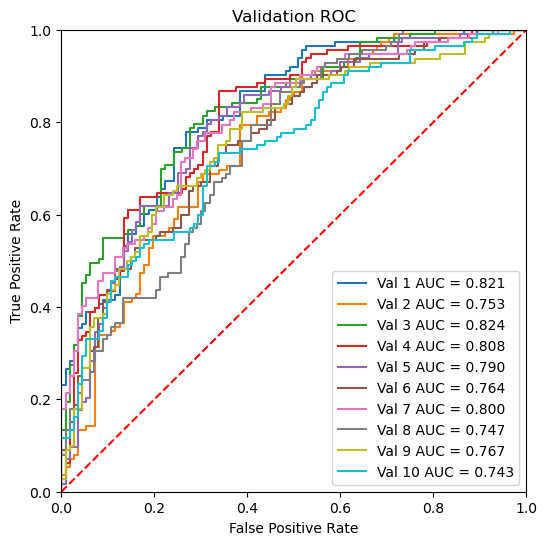

In [43]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_val.png')
plt.show()

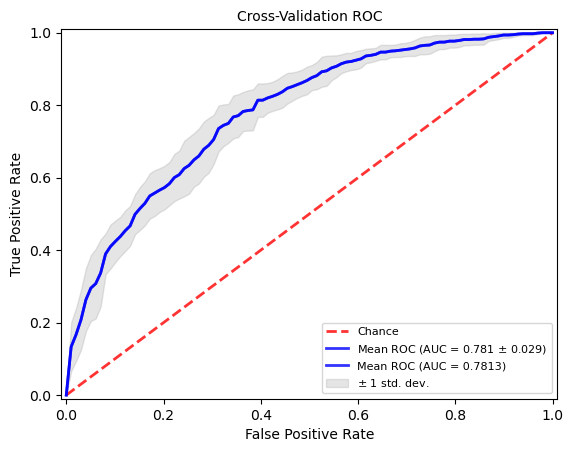

In [44]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_val_mean.png')
plt.show()

In [45]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [46]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [47]:
my_calculate_metrics_list_val

[{'SN': 0.8230088495575221,
  'SP': 0.6160714285714286,
  'ACC': 0.72,
  'MCC': 0.44898073462343824,
  'Recall': 0.8230088495575221,
  'Precision': 0.6838235294117647,
  'F1-score': 0.7469879518072289,
  'Cutoff': 0.5},
 {'SN': 0.6071428571428571,
  'SP': 0.75,
  'ACC': 0.6785714285714286,
  'MCC': 0.36084391824351614,
  'Recall': 0.6071428571428571,
  'Precision': 0.7083333333333334,
  'F1-score': 0.6538461538461539,
  'Cutoff': 0.5},
 {'SN': 0.8761061946902655,
  'SP': 0.5357142857142857,
  'ACC': 0.7066666666666667,
  'MCC': 0.4382801891951803,
  'Recall': 0.8761061946902655,
  'Precision': 0.6556291390728477,
  'F1-score': 0.75,
  'Cutoff': 0.5},
 {'SN': 0.7787610619469026,
  'SP': 0.6607142857142857,
  'ACC': 0.72,
  'MCC': 0.44266978697347825,
  'Recall': 0.7787610619469026,
  'Precision': 0.6984126984126984,
  'F1-score': 0.7364016736401674,
  'Cutoff': 0.5},
 {'SN': 0.8584070796460177,
  'SP': 0.5714285714285714,
  'ACC': 0.7155555555555555,
  'MCC': 0.4489744964193175,
  'Reca

In [48]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.823009,0.616071,0.720000,0.448981,0.823009,0.683824,0.746988,0.5
1,0.607143,0.750000,0.678571,0.360844,0.607143,0.708333,0.653846,0.5
2,0.876106,0.535714,0.706667,0.438280,0.876106,0.655629,0.750000,0.5
3,0.778761,0.660714,0.720000,0.442670,0.778761,0.698413,0.736402,0.5
4,0.858407,0.571429,0.715556,0.448974,0.858407,0.668966,0.751938,0.5
5,0.794643,0.557522,0.675556,0.362358,0.794643,0.640288,0.709163,0.5
6,0.883929,0.522124,0.702222,0.435230,0.883929,0.647059,0.747170,0.5
7,0.830357,0.548673,0.688889,0.394819,0.830357,0.645833,0.726562,0.5
8,0.669643,0.707965,0.688889,0.377906,0.669643,0.694444,0.681818,0.5
9,0.562500,0.750000,0.656250,0.318142,0.562500,0.692308,0.620690,0.5


In [49]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.823009,0.616071,0.720000,0.448981,0.823009,0.683824,0.746988,0.5
1,0.607143,0.750000,0.678571,0.360844,0.607143,0.708333,0.653846,0.5
2,0.876106,0.535714,0.706667,0.438280,0.876106,0.655629,0.750000,0.5
3,0.778761,0.660714,0.720000,0.442670,0.778761,0.698413,0.736402,0.5
4,0.858407,0.571429,0.715556,0.448974,0.858407,0.668966,0.751938,0.5
5,0.794643,0.557522,0.675556,0.362358,0.794643,0.640288,0.709163,0.5
6,0.883929,0.522124,0.702222,0.435230,0.883929,0.647059,0.747170,0.5
7,0.830357,0.548673,0.688889,0.394819,0.830357,0.645833,0.726562,0.5
8,0.669643,0.707965,0.688889,0.377906,0.669643,0.694444,0.681818,0.5
9,0.562500,0.750000,0.656250,0.318142,0.562500,0.692308,0.620690,0.5


In [50]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\result\CNN_OH_performance_val.csv',encoding='utf-8')

独立测试

In [51]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [52]:
roc_auc_list_indep

[0.7863520408163265,
 0.8171237244897959,
 0.7932876275510204,
 0.7793367346938775,
 0.7618781887755102,
 0.8010204081632654,
 0.7681760204081632,
 0.7518335459183674,
 0.767936862244898,
 0.8064413265306122]

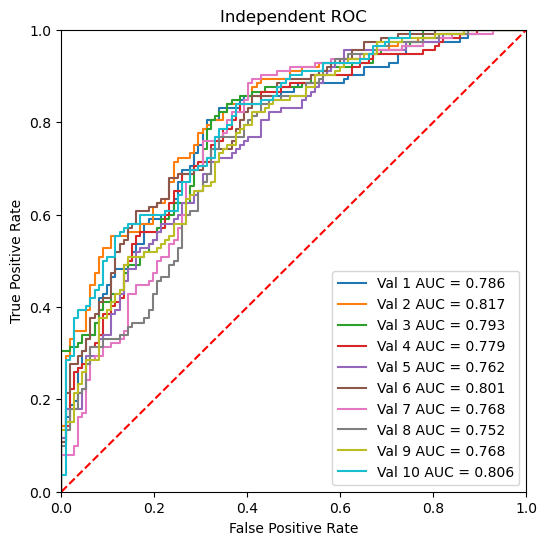

In [53]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_indep.png')
plt.show()

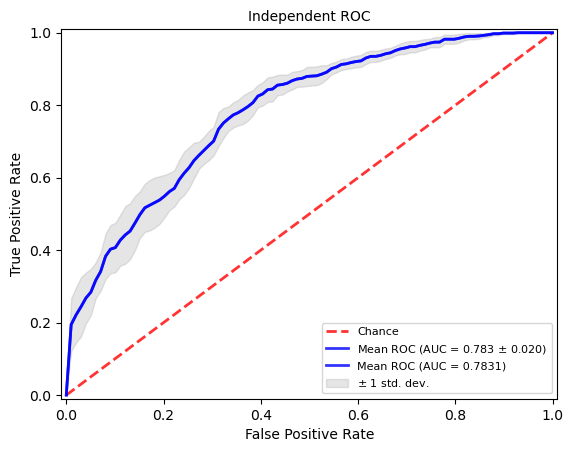

In [54]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_indep_mean.png')
plt.show()

In [55]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [56]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [57]:
my_calculate_metrics_list_indep

[{'SN': 0.8303571428571429,
  'SP': 0.6428571428571429,
  'ACC': 0.7366071428571429,
  'MCC': 0.481758463395946,
  'Recall': 0.8303571428571429,
  'Precision': 0.6992481203007519,
  'F1-score': 0.7591836734693878,
  'Cutoff': 0.5},
 {'SN': 0.6428571428571429,
  'SP': 0.7678571428571429,
  'ACC': 0.7053571428571429,
  'MCC': 0.4139610894862965,
  'Recall': 0.6428571428571429,
  'Precision': 0.7346938775510204,
  'F1-score': 0.6857142857142857,
  'Cutoff': 0.5},
 {'SN': 0.875,
  'SP': 0.5625,
  'ACC': 0.71875,
  'MCC': 0.4605661864718383,
  'Recall': 0.875,
  'Precision': 0.6666666666666666,
  'F1-score': 0.7567567567567568,
  'Cutoff': 0.5},
 {'SN': 0.7321428571428571,
  'SP': 0.6785714285714286,
  'ACC': 0.7053571428571429,
  'MCC': 0.4113049113404077,
  'Recall': 0.7321428571428571,
  'Precision': 0.6949152542372882,
  'F1-score': 0.7130434782608696,
  'Cutoff': 0.5},
 {'SN': 0.8035714285714286,
  'SP': 0.5625,
  'ACC': 0.6830357142857143,
  'MCC': 0.3771959263059937,
  'Recall': 0.80

In [58]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.830357,0.642857,0.736607,0.481758,0.830357,0.699248,0.759184,0.5
1,0.642857,0.767857,0.705357,0.413961,0.642857,0.734694,0.685714,0.5
2,0.875000,0.562500,0.718750,0.460566,0.875000,0.666667,0.756757,0.5
3,0.732143,0.678571,0.705357,0.411305,0.732143,0.694915,0.713043,0.5
4,0.803571,0.562500,0.683036,0.377196,0.803571,0.647482,0.717131,0.5
5,0.776786,0.625000,0.700893,0.406496,0.776786,0.674419,0.721992,0.5
6,0.839286,0.607143,0.723214,0.458967,0.839286,0.681159,0.752000,0.5
7,0.857143,0.526786,0.691964,0.406766,0.857143,0.644295,0.735632,0.5
8,0.633929,0.732143,0.683036,0.367850,0.633929,0.702970,0.666667,0.5
9,0.598214,0.830357,0.714286,0.440608,0.598214,0.779070,0.676768,0.5


In [59]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.830357,0.642857,0.736607,0.481758,0.830357,0.699248,0.759184,0.5
1,0.642857,0.767857,0.705357,0.413961,0.642857,0.734694,0.685714,0.5
2,0.875000,0.562500,0.718750,0.460566,0.875000,0.666667,0.756757,0.5
3,0.732143,0.678571,0.705357,0.411305,0.732143,0.694915,0.713043,0.5
4,0.803571,0.562500,0.683036,0.377196,0.803571,0.647482,0.717131,0.5
5,0.776786,0.625000,0.700893,0.406496,0.776786,0.674419,0.721992,0.5
6,0.839286,0.607143,0.723214,0.458967,0.839286,0.681159,0.752000,0.5
7,0.857143,0.526786,0.691964,0.406766,0.857143,0.644295,0.735632,0.5
8,0.633929,0.732143,0.683036,0.367850,0.633929,0.702970,0.666667,0.5
9,0.598214,0.830357,0.714286,0.440608,0.598214,0.779070,0.676768,0.5


In [60]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_Acet_Ubi\base_data\data_5k_Acet&Ubi\result\CNN_OH_performance_indep.csv',encoding='utf-8')

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

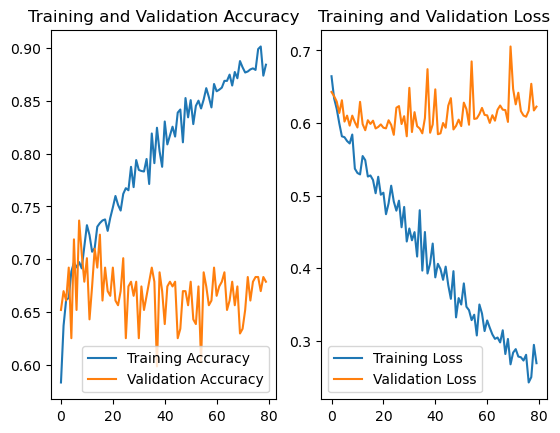

In [62]:
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()